## This Notebook is for generating the training data for DeNoising Module

#### Target:
    - craete patches of 128 x 128 size. 
    - remove background 
    - define thrashold to select eligable patches for training. 

In [13]:
import numpy as np
import matplotlib.pyplot as plt 
from data_gen import create_folders_DN, create_patches, RawData
from csbdeep.utils import plot_some
import ipywidgets as widgets
import os
from augmentation import flip_up_down, flip_left_right, transpose,  rotate_90, rotate_180, rotate_270
import random

## Pass the data folder. 
-  stracture(F-Actins): 
    -    cell(0-55): 
            -  RawSIMData_gt.MRC , image: [C:9 x W:502 x H502  9 : target for Denoising and keeping the stracture
            -  RawSIMData_level_(01-012).mrc , image :  [C:9 x W:502 x H:502] : make input patches for training
            -  SIM_gt.mrc , image [C:1 x W:104 x H:104] : target data for Super resoulation Image Generation 

Image Axis: X/W: columns, Y/H: rows, Z: planes, C: channels, T: frames/time, (S: samples/images)

In [2]:
root_dir = '../F-actin'
create_folders_DN(root_dir, gt_filename="RawSIMData_gt",
    raw_filename="RawSIMData_level_04")

c:\Users\ASARKER\miniconda3\envs\thesis\lib\site-packages\mrcfile\mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
c:\Users\ASARKER\miniconda3\envs\thesis\lib\site-packages\mrcfile\mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


In [3]:
patch_size_xy = 128
patch_size_z = 9
n_patches_per_image = 5

In [4]:
raw_data = RawData.from_folder (
    basepath    = f'{root_dir}/Train/DN',
    source_dirs = ['Raw'],
    target_dir  = 'GT',
    axes        = 'ZYX',
)

In [5]:
X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (patch_size_z,patch_size_xy,patch_size_xy),
    n_patches_per_image = n_patches_per_image,
    save_file           = f'{root_dir}/Train/DN/f-actin_DN.npz',
)

   50 raw images x    1 transformations   =    50 images
   50 images     x    5 patches per image =   250 patches in total
Input data:
../F-actin/Train/DN: target='GT', sources=['Raw'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Identity
128 x 128
Patch size:
9 x 128 x 128


100%|██████████| 50/50 [01:07<00:00,  1.36s/it]


Saving data to ..\F-actin\Train\DN\f-actin_DN.npz.


#### Info: Image DN

In [6]:
print("shape of Input  Image  : X   = ", X.shape) # Expected: X (Raw/inpout image: C:W:H :: 9:128:128)
print("shape of Ground Truth Image : Y   = ", Y.shape) # Expected: Y (GT/target image: C:W:H :: 1:128:128)
print("axes  of X , Y =", XY_axes) # gives us, how the image is stored in the array. Samples, channel

shape of Input  Image  : X   =  (250, 1, 9, 128, 128)
shape of Ground Truth Image : Y   =  (250, 1, 9, 128, 128)
axes  of X , Y = SCZYX


##### Visualization of the images

In [7]:
def plot_patches_on_demand(X, Y):
    def plot_patches(i):
        plt.figure(figsize=(10, 10))
        sl = slice(i,  (i + 1)), 0
        plot_some(X[sl], Y[sl], title_list=[np.arange(sl[0].start, sl[0].stop)])
        plt.show()

    i_slider = widgets.IntSlider(value=0, min=0, max=X.shape[0] -1, description='Index:')
    widgets.interact(plot_patches, i=i_slider)

plot_patches_on_demand(X, Y)

interactive(children=(IntSlider(value=0, description='Index:', max=249), Output()), _dom_classes=('widget-inte…

### Do the data augmentation
-   6 augmented image + 1 original image. 
-   data increases 7 times

In [8]:
def viz_aug(X, Y):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    print(f'from visualizer : X {X.shape} {X.dtype}] : Y : {Y.shape} {Y.dtype} ')

    axes[0].imshow(X[...,1], cmap='viridis')
    axes[0].set_title('Augmented Image X')
    axes[0].axis('off')

    axes[1].imshow(Y, cmap='viridis')
    axes[1].set_title('Augmented Image Y')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()



def npz_info(file):
    npz_file = file

    try:
        data = np.load(npz_file)
    except IOError as e:
        print(f"Error loading .npz file: {e}")

    print(data)
    # Print the shape and dtype of each array in the .npz file
    for key in data.keys():
        print(f"{key} shape: {data[key].shape}, dtype: {data[key].dtype}")



def apply_augmentations_and_save(npz_file):
    try:
        data = np.load(npz_file)
    except IOError as e:
        print(f"Error loading .npz file: {e}")
        return
    
    if 'X' not in data or 'Y' not in data:
        print("Error: .npz file does not contain 'X' or 'Y' keys.")
        return
    #
    X = data['X']
    Y = data['Y']
    
    print(f"X shape before processing: {X.shape} {X.dtype}, Y shape before processing: {Y.shape} {Y.dtype}")

    augmented_X = []
    augmented_Y = []

    # augmentations = [
    #     ('flip_up_down', flip_up_down),
    #     ('flip_left_right', flip_left_right),
    #     ('transpose', transpose),
    #     ('rotate_90', rotate_90),
    #     ('rotate_180', rotate_180),
    #     ('rotate_270', rotate_270)
    # ]
    augmentations = [flip_up_down, flip_left_right, transpose,  rotate_90, rotate_180, rotate_270]
    for i in range(X.shape[0]):
        ori_X = X[i, 0].transpose(1, 2, 0)
        ori_Y = Y[i, 0].transpose(1, 2, 0)
        print(f'checking original image shapes :ori_X {ori_X.shape} : ori_Y {ori_Y.shape}')
        augmented_X.append(np.expand_dims(ori_X.transpose(2, 0, 1),axis=0))
        augmented_Y.append(np.expand_dims(ori_Y.transpose(2, 0, 1),axis=0))

        for aug_fn in augmentations:
            print(f'this is aug_fun : {aug_fn} ' )
            print(f' augmentation input , X : {X[i, 0].transpose(1, 2, 0).shape} , Y : {Y[i, 0].transpose(1, 2, 0).shape}') # augmentation input , X : (128, 128, 9) , Y : (256, 256, 1)
            aug_X, aug_Y = aug_fn(X[i, 0].transpose(1, 2, 0), Y[i, 0].transpose(1, 2, 0))
            
            # for vizualizing the augmentation
            #viz_aug(aug_X, aug_Y)

            print(f'augmentation outoput: aug_X : {aug_X.shape} aug_Y : {aug_Y.shape} ') # augmentation outoput: aug_X : (128, 128, 9) aug_Y : (256, 256, 1) 
            print(f'being added to the array :aug_X.transpose(2, 0, 1) {aug_X.transpose(2, 0, 1).shape} : aug_Y.transpose(2, 0, 1) {aug_Y.transpose(2, 0, 1).shape}') #being added to the array :aug_X.transpose(2, 0, 1) (9, 128, 128) : aug_Y.transpose(2, 0, 1) (1, 256, 256)
            augmented_X.append(np.expand_dims(aug_X.transpose(2, 0, 1),axis=0))
            augmented_Y.append(np.expand_dims(aug_Y.transpose(2, 0, 1),axis=0))

    augmented_X = np.array(augmented_X)
    augmented_Y = np.array(augmented_Y)
    print(f'augmented_X : {augmented_X.shape} : augmented_Y:{augmented_Y.shape}') # augmented_X : (15300, 1, 9, 128, 128) : augmented_Y:(15300, 1, 1, 256, 256)
    directory_path = os.path.join(*npz_file.split('/')[:-1]) + '/'
    print(f'directory_path : {directory_path}')#
    base_name = os.path.basename(npz_file)



    np.savez(directory_path + f'augmented_{base_name}', X=augmented_X, Y=augmented_Y, axes=data['axes'])
    print(f"Augmented data saved to augmented_{base_name}")
npz_file =  '../F-actin/Train/DN/f-actin_DN.npz'
apply_augmentations_and_save(npz_file)


X shape before processing: (250, 1, 9, 128, 128) float32, Y shape before processing: (250, 1, 9, 128, 128) float32
checking original image shapes :ori_X (128, 128, 9) : ori_Y (128, 128, 9)
this is aug_fun : <function flip_up_down at 0x0000024589A3FD00> 
 augmentation input , X : (128, 128, 9) , Y : (128, 128, 9)
augmentation outoput: aug_X : (128, 128, 9) aug_Y : (128, 128, 9) 
being added to the array :aug_X.transpose(2, 0, 1) (9, 128, 128) : aug_Y.transpose(2, 0, 1) (9, 128, 128)
this is aug_fun : <function flip_left_right at 0x0000024589A3FC70> 
 augmentation input , X : (128, 128, 9) , Y : (128, 128, 9)
augmentation outoput: aug_X : (128, 128, 9) aug_Y : (128, 128, 9) 
being added to the array :aug_X.transpose(2, 0, 1) (9, 128, 128) : aug_Y.transpose(2, 0, 1) (9, 128, 128)
this is aug_fun : <function transpose at 0x0000024589A3F880> 
 augmentation input , X : (128, 128, 9) , Y : (128, 128, 9)
augmentation outoput: aug_X : (128, 128, 9) aug_Y : (128, 128, 9) 
being added to the arra

### Information regarding the Denoising (DN) .npz files

In [9]:
def npz_info(file):
    npz_file = file

    try:
        data = np.load(npz_file)
    except IOError as e:
        print(f"Error loading .npz file: {e}")

    print(data)
    # Print the shape and dtype of each array in the .npz file
    for key in data.keys():
        print(f"{key} shape: {data[key].shape}, dtype: {data[key].dtype}")

In [10]:
print('before augmentation \n')
npz_info('../F-actin/Train/DN/f-actin_DN.npz')
print('\nafter augmentation\n')
npz_info('../F-actin/Train/DN/augmented_f-actin_DN.npz')

before augmentation 

NpzFile '../F-actin/Train/DN/f-actin_DN.npz' with keys: X, Y, axes
X shape: (250, 1, 9, 128, 128), dtype: float32
Y shape: (250, 1, 9, 128, 128), dtype: float32
axes shape: (), dtype: <U5

after augmentation

NpzFile '../F-actin/Train/DN/augmented_f-actin_DN.npz' with keys: X, Y, axes
X shape: (1750, 1, 9, 128, 128), dtype: float32
Y shape: (1750, 1, 9, 128, 128), dtype: float32
axes shape: (), dtype: <U5


### visualize the augmentation

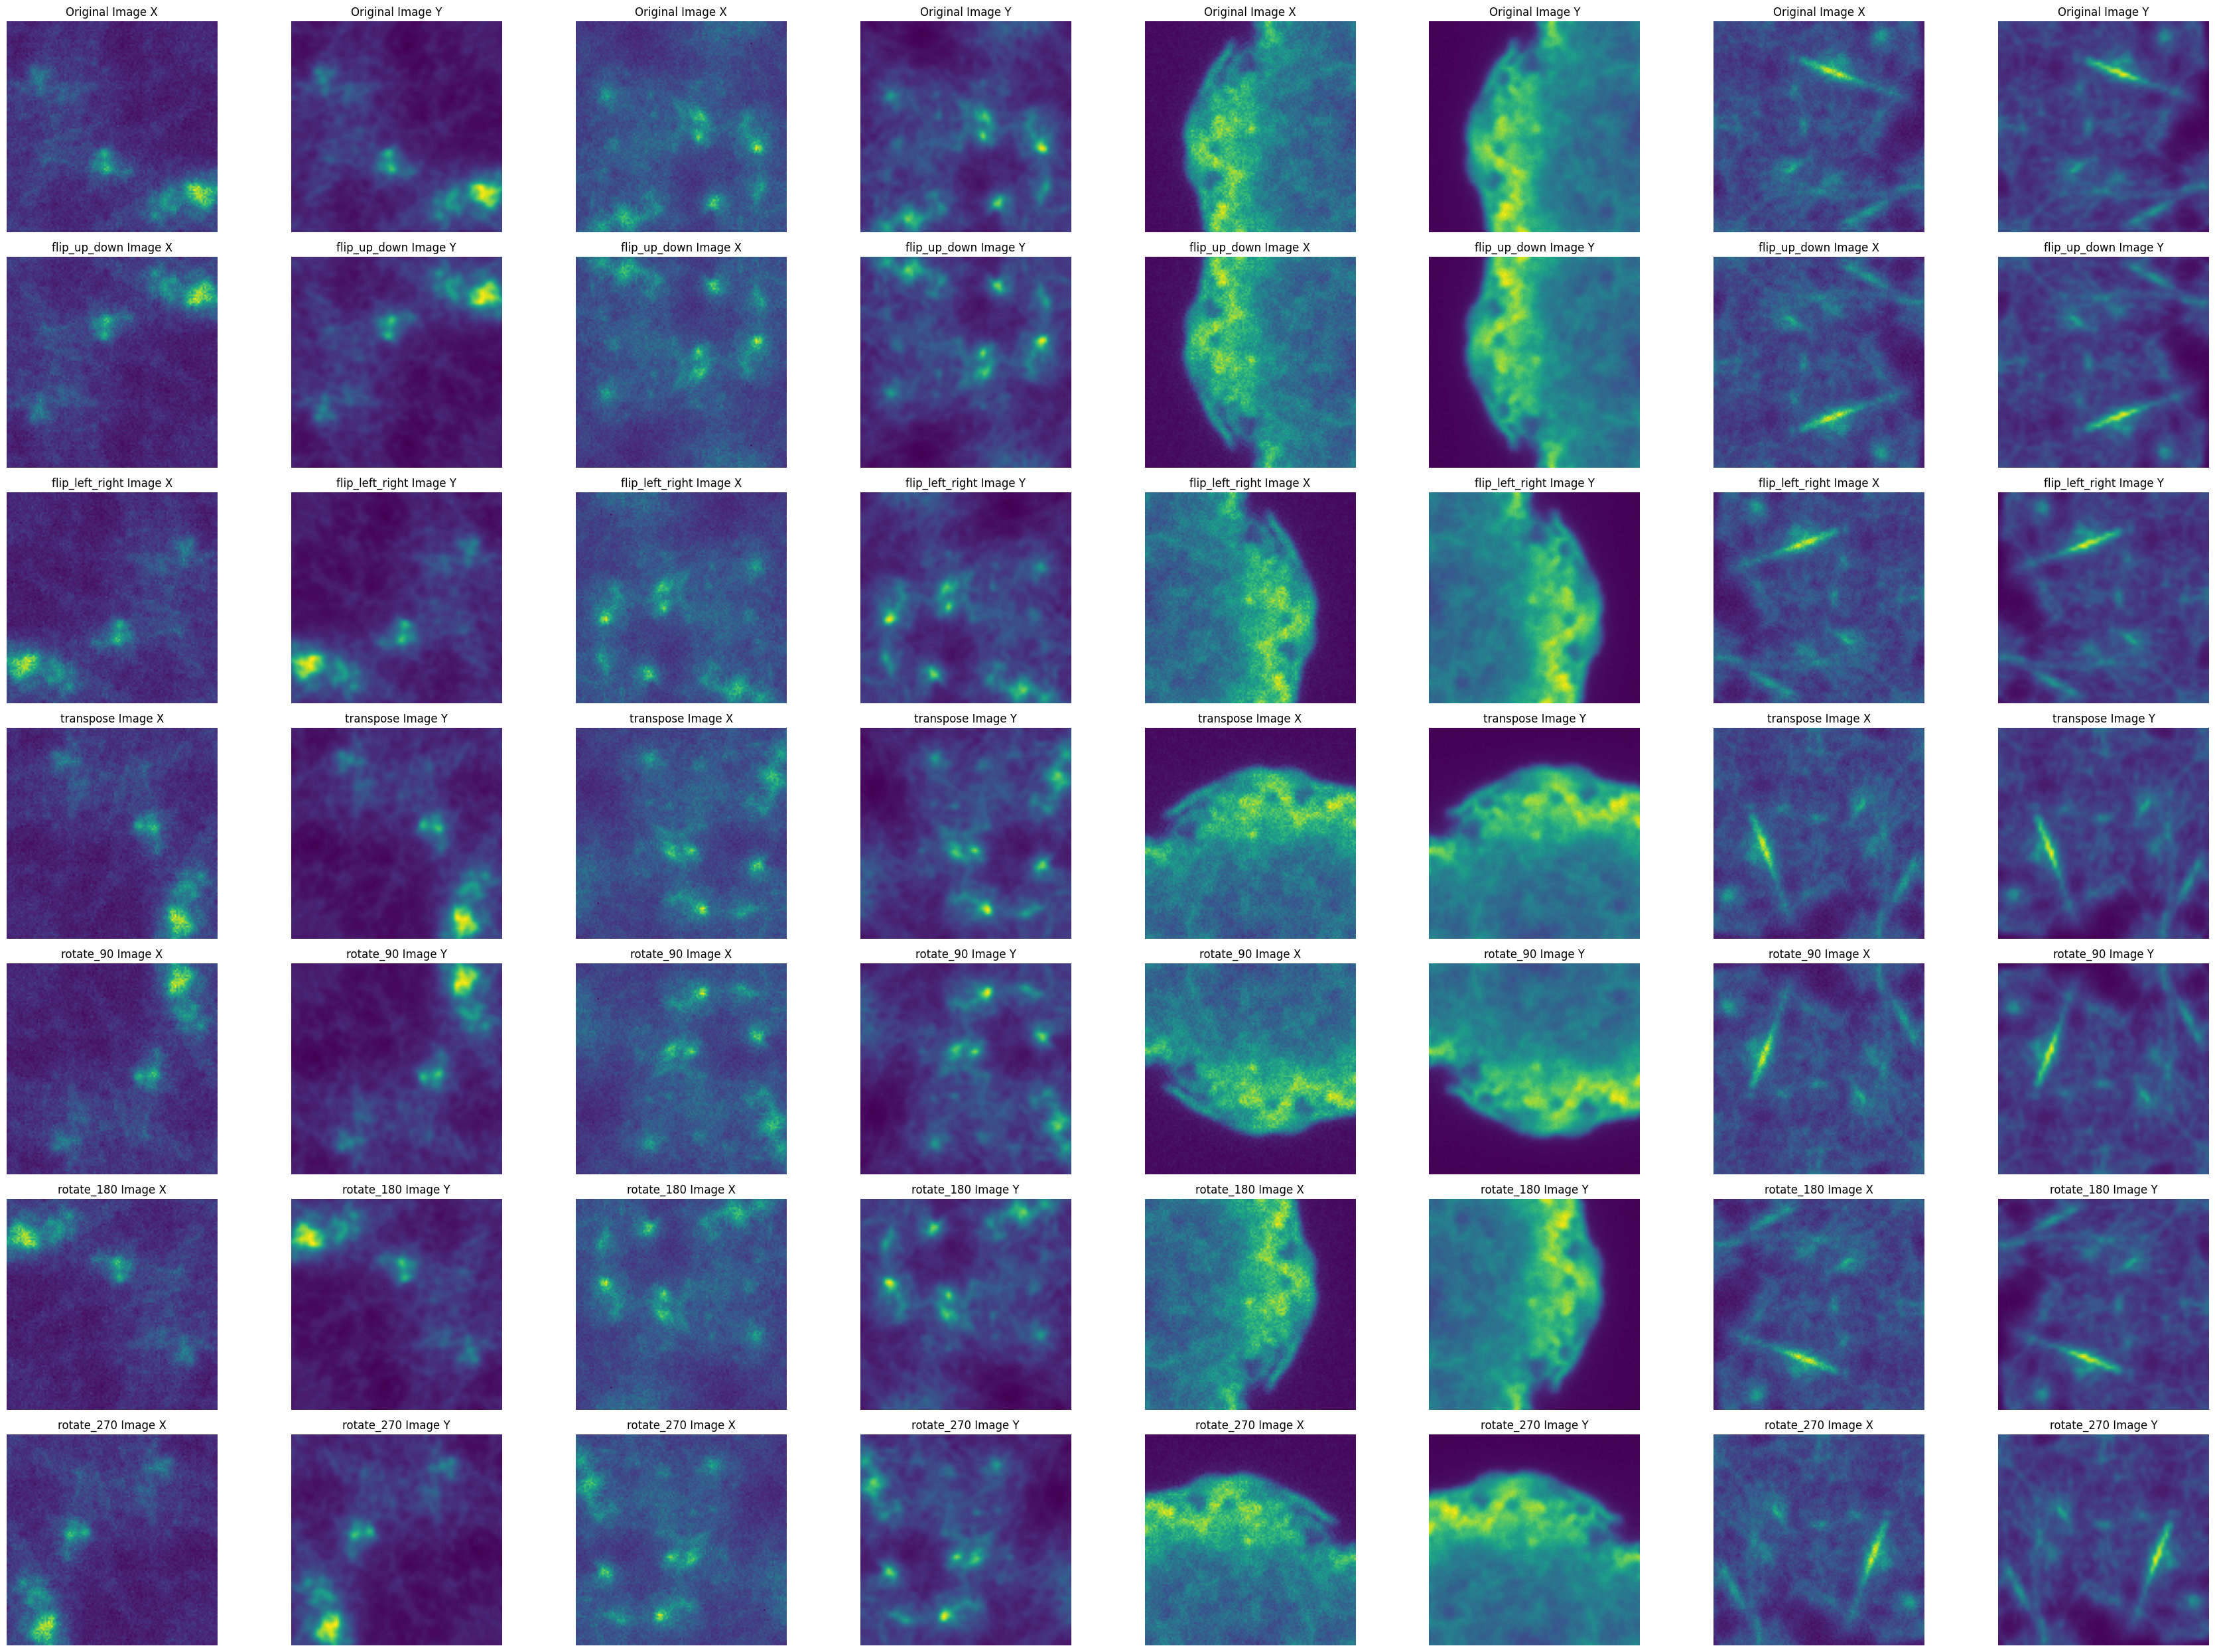

In [22]:
def visualize_XY_from_npz(npz_file, num_samples):
    try:
        data = np.load(npz_file)
    except IOError as e:
        print(f"Error loading .npz file: {e}")
        return
    
    if 'X' not in data or 'Y' not in data:
        print("Error: .npz file does not contain 'X' or 'Y' keys.")
        return
    
    X = data['X']
    Y = data['Y']
    
    # print(f"X shape before processing: {X.shape} {X.dtype}, Y shape before processing: {Y.shape} {Y.dtype}")
    # output: X shape before processing: (2550, 1, 9, 128, 128) float32, Y shape before processing: (2550, 1, 1, 256, 256) float32
    
    # Randomly select 5 data points
    num_examples = num_samples
    indices = np.random.choice(X.shape[0], num_examples, replace=False)
    X = X[indices]
    Y = Y[indices]
    
    # augmentation functions
    augmentations = [
        ('flip_up_down', flip_up_down),
        ('flip_left_right', flip_left_right),
        ('transpose', transpose),
        ('rotate_90', rotate_90),
        ('rotate_180', rotate_180),
        ('rotate_270', rotate_270)
    ]
    
    # Apply augmentations and visualize
    fig, axes = plt.subplots(len(augmentations) + 1, num_examples * 2, figsize=(35, 25)) # row, column, fig size
    
    for i in range(num_examples):
        # Display original images
        X_img = X[i, 0, 0]  # Get the first slice of the image as its a 9 channel image, only the 1st channel
        Y_img = Y[i, 0, 0]  # Get the first slice of the image as its a 9 channel image
        #print(f'shape after changing dimension : X : { X_img.shape} : Y : {Y_img.shape} ')
        #output: shape after changing dimension : X : (128, 128) : Y : (256, 256)

        axes[0, i * 2].imshow(X_img, cmap='viridis')
        axes[0, i * 2].set_title('Original Image X', fontsize=12)
        axes[0, i * 2].axis('off')

        axes[0, i * 2 + 1].imshow(Y_img, cmap='viridis')
        axes[0, i * 2 + 1].set_title('Original Image Y', fontsize=12)
        axes[0, i * 2 + 1].axis('off')
        
        # # for showing image info
        # for ax, img in zip([axes[0, i * 2], axes[0, i * 2 + 1]], [X_img, Y_img]):
        #     textstr = f'Dtype: {img.dtype}\nShape: {img.shape}\nMin: {img.min()}\nMax: {img.max()}'
        #     ax.text(0.5, -0.2, textstr, va='center', ha='center', transform=ax.transAxes, fontsize=8, color='white', bbox=dict(facecolor='black', alpha=0.5))

        # Apply augmentations and plot
        for j, (aug_name, aug_fn) in enumerate(augmentations, start=1):
            aug_X, aug_Y = aug_fn(X_img, Y_img)
            
            axes[j, i * 2].imshow(aug_X, cmap='viridis')
            axes[j, i * 2].set_title(f'{aug_name} Image X', fontsize=12)
            axes[j, i * 2].axis('off')

            axes[j, i * 2 + 1].imshow(aug_Y, cmap='viridis')
            axes[j, i * 2 + 1].set_title(f'{aug_name} Image Y', fontsize=12)
            axes[j, i * 2 + 1].axis('off')
            
            # For showing image info
            # for ax, img in zip([axes[j, i * 2], axes[j, i * 2 + 1]], [aug_X, aug_Y]):
            #     textstr = f'Dtype: {img.dtype}\nShape: {img.shape}\nMin: {img.min()}\nMax: {img.max()}'
            #     ax.text(0.5, -0.2, textstr, va='center', ha='center', transform=ax.transAxes, fontsize=8, color='white', bbox=dict(facecolor='black', alpha=0.5))
        
    plt.tight_layout()
    plt.show()
    plt.savefig('augmented_f-actin_DN_examples.png', bbox_inches='tight')

# Example usage
npz_file = '../F-actin/Train/DN/augmented_f-actin_DN.npz' # Replace with your .npz file path
visualize_XY_from_npz( npz_file, 4)
